# Testing the two-level asymptotic form of `Whirl2d`

In [244]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body undergoing a weak oscillatory translation in `x` direction 

In [259]:
Npts = 64
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b1 = Bodies.Circle(Npts,rad,xcent,ang)

xcent = [2.0,0.0]
b2 = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 64, reference point = (2.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Set the streaming motion

In [260]:
nbody = 2
Ω = 1.0
T = 2π/Ω
X₁ = 1.0
X₂ = 0.0
Y₁ = 0.0
Y₂ = 0.0
ϕx₁ = 0.0
ϕy₁ = 0.0
ϕx₂ = 0.0
ϕy₂ = 0.0
sparams = Array{NavierStokes.StreamingParams}(nbody)
sparams[1] = NavierStokes.StreamingParams(Ω,X₁,ϕx₁,Y₁,ϕy₁)
NavierStokes.set_oscil_motion!(b1,sparams[1])

sparams[2] = NavierStokes.StreamingParams(Ω,X₂,ϕx₂,Y₂,ϕx₂)
NavierStokes.set_oscil_motion!(b2,sparams[2])

(::X) (generic function with 1 method)

### Create a domain with this body in it

In [261]:
xmin = [-2.0,-2.0]
xmax = [2.0,2.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b1)
dom = Systems.add_body(dom,b2)

Domain: xmin = [-2.0, -2.0], xmax = [2.5, 2.0]
number of bodies = 2
Body: number of points = 64, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Body: number of points = 64, reference point = (2.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [262]:
Δx = 0.04
dom = Systems.add_grid(dom,Δx)
x = Grids.xcell(dom.grid);
y = Grids.ycell(dom.grid);

### Set the physical and time parameters

In [263]:
Re = 320
physparams = NavierStokes.set_freestream([0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α,sparams)
tparams

Time step size 0.02

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [264]:
@time ops = NavierStokes.set_operators_two_level_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

  5.999092 seconds (370.94 k allocations: 758.950 MiB, 2.60% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.L⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [265]:
s = NavierStokes.TwoLevelBodySoln(dom)
s.ψ = -L⁻¹(s.u);
TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
hist = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Array{Float64,2},1},Array{Array{Float64,2},1}},1}:
 Solution: t = 0.0


### Advance the solution

In [266]:
@time for i = 1:ceil(Int,T/tparams.Δt)
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
    s.ψ = -L⁻¹(s.u);
    push!(hist,s)
end
s

 77.332666 seconds (2.44 M allocations: 6.838 GiB, 2.32% gc time)


Solution: t = 6.299999999999954


#### Average over the last period

In [267]:
savg = NavierStokes.TwoLevelBodySoln(dom)
nper = floor(Int,T/tparams.Δt)
for i in length(hist)-nper+1:length(hist)
    savg.u .+= hist[i].u
    savg.ψ .+= hist[i].ψ
end
savg.u ./= nper
savg.ψ ./= nper

2-element Array{Array{Float64,2},1}:
 [0.0221447 0.0221549 … -0.0221549 -0.0221447; 0.0225914 0.0226111 … -0.0226111 -0.0225914; … ; 0.013318 0.0131534 … -0.0131534 -0.013318; 0.0130222 0.0128566 … -0.0128566 -0.0130222]
 [0.527223 0.53669 … -0.53669 -0.527223; 0.537586 0.547662 … -0.547662 -0.537586; … ; -0.239742 -0.241502 … 0.241502 0.239742; -0.232838 -0.234377 … 0.234377 0.232838]                

### Plot the solution

#### Level 1 solution

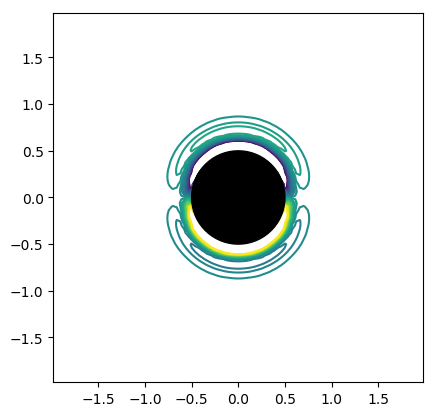

(-1.98, 1.98, -1.98, 1.98)

In [254]:
contour(x,y,hist[125].u[1][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-5,5,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

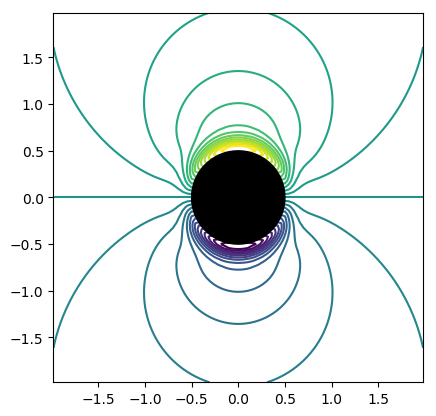

(-1.98, 1.98, -1.98, 1.98)

In [255]:
contour(x,y,hist[250].ψ[1][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

#### Level 2 mean solution

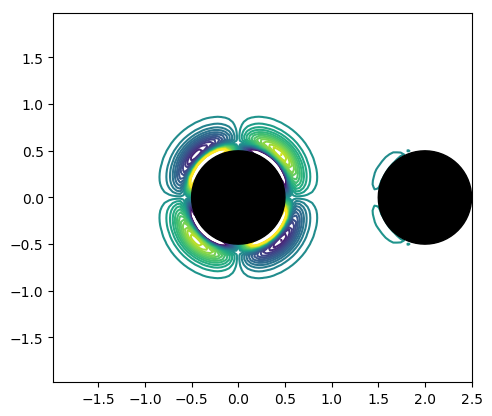

(-1.98, 2.5, -1.98, 1.98)

In [268]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,savg.u[2][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-20,20,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

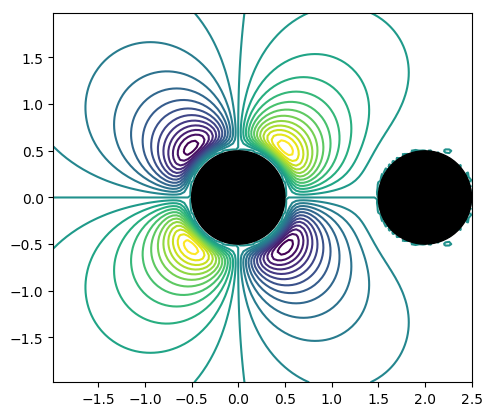

(-1.98, 2.5, -1.98, 1.98)

In [269]:
contour(x,y,savg.ψ[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

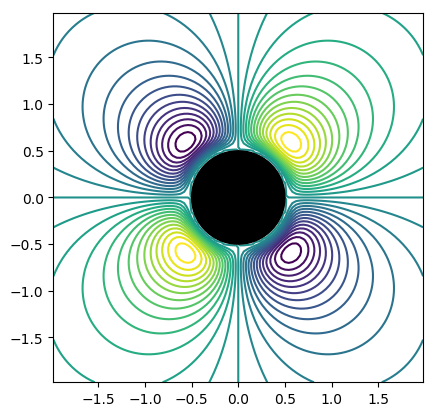

(-1.98, 1.98, -1.98, 1.98)

In [211]:
contour(x,y,hist[628].ψ[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

In [65]:
size(hist)

(51,)

In [78]:
hist[10].ψ

2-element Array{Array{Float64,2},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [219]:
im*5

0 + 5im

In [506]:
include(joinpath(Pkg.dir("whirl2d"), "src/Streaming.jl"))
import Streaming

In [507]:
Re = 80
p = Streaming.Params(Re)
xmin = -8.0
xmax = 8.0
N = 301
x = [xmin + (j-1)*(xmax-xmin)/(N-1) for i=1:N, j=1:N];
y = [xmin + (i-1)*(xmax-xmin)/(N-1) for i=1:N, j=1:N];
Nᵣ = 500
rmax = √2*xmax
r = collect(linspace(1,rmax,Nᵣ))
g = Streaming.Grid(x,y)

2-dimensional evaluation grid


In [473]:
s0 = Streaming.FirstOrder(p,r)

Amplitude of order 1 streaming exact solution


In [509]:
Ir,t1,t2,t3,t4,fint = Streaming.SecondOrder(p,r)

(Complex{Float64}[-3.86271+0.0im, -3.82618+0.0im, -3.58517+0.0im, -3.17662+0.0im, -2.6326+0.0im, -1.98202+0.0im, -1.25159+0.0im, -0.46619+0.0im, 0.350948+0.0im, 1.1784+0.0im  …  5.85647+0.0im, 5.85654+0.0im, 5.8566+0.0im, 5.85667+0.0im, 5.85674+0.0im, 5.85681+0.0im, 5.85687+0.0im, 5.85694+0.0im, 5.857+0.0im, 5.85707+0.0im], Complex{Float64}[1.29418-0.0im, 1.37507-0.0im, 1.40872-0.0im, 1.40169-0.0im, 1.35971-0.0im, 1.28812-0.0im, 1.19203-0.0im, 1.07642-0.0im, 0.946166-0.0im, 0.805966-0.0im  …  4.23193e-25-0.0im, 3.46444e-25-0.0im, 2.76726e-25-0.0im, 2.14499e-25-0.0im, 1.59903e-25-0.0im, 1.12826e-25-0.0im, 7.29614e-26-0.0im, 3.9861e-26-0.0im, 1.29801e-26-0.0im, -8.2855e-27-0.0im], Complex{Float64}[-4.87876+0.0im, -4.99533+0.0im, -4.96063+0.0im, -4.79957+0.0im, -4.53386+0.0im, -4.18323+0.0im, -3.76607+0.0im, -3.29979+0.0im, -2.80087+0.0im, -2.28474+0.0im  …  -1.27898e-24+0.0im, -1.04448e-24+0.0im, -8.31884e-25+0.0im, -6.42486e-25+0.0im, -4.76625e-25+0.0im, -3.33879e-25+0.0im, -2.13247e-25

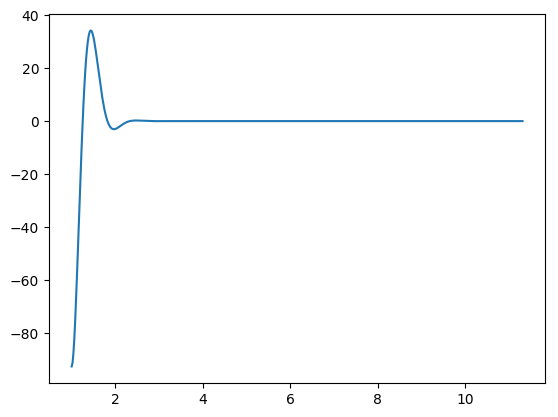

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x34b56d7d0>

In [514]:
plot(r,real.(fint.(r,3)))

In [444]:
t = 0.0
s = Streaming.Evaluate(t,g,s0)

Order 1 streaming exact solution at t = 0.0


In [418]:
maximum(abs.(s0.ω))

18.553844811510114

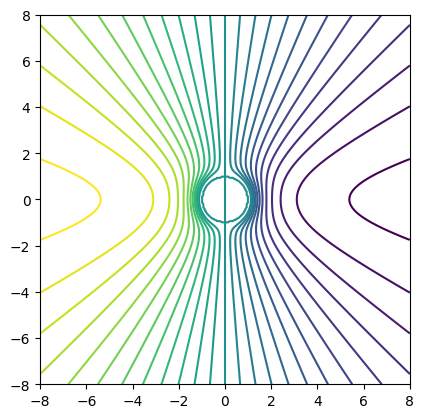

(-8.0, 8.0, -8.0, 8.0)

In [455]:
contour(g.x,g.y,s.ur,31)
axis("scaled")

In [448]:
s.ω[170,151]

12.27059073792416

In [446]:
g.y[170,151]

1.0434782608695645

In [457]:
?conj

search: conj conj! ConjArray ConjVector ConjMatrix conv cond const conv2 convert



```
conj(z)
```

Compute the complex conjugate of a complex number `z`.

```jldoctest
julia> conj(1 + 3im)
1 - 3im
```

```
conj(v::RowVector)
```

Returns a [`ConjArray`](@ref) lazy view of the input, where each element is conjugated.

### Example

```jldoctest
julia> v = [1+im, 1-im].'
1×2 RowVector{Complex{Int64},Array{Complex{Int64},1}}:
 1+1im  1-1im

julia> conj(v)
1×2 RowVector{Complex{Int64},ConjArray{Complex{Int64},1,Array{Complex{Int64},1}}}:
 1-1im  1+1im
```
